In [19]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
import time

In [20]:
# read data
df_train = pd.read_csv('data/merged_train.csv')
df_test = pd.read_csv('data/merged_test.csv')

In [21]:
df_train.shape, df_test.shape

((6941, 13), (2975, 12))

In [22]:
df_train.label.value_counts()

0    6609
1     332
Name: label, dtype: int64

In [23]:
df_train.columns

Index(['account_id', 'amount_donated_2013', 'amount_donated_lifetime',
       'no_donations_lifetime', 'label', 'no_seats_tickets',
       'price_level_tickets', 'no_seats_subs', 'price_level_subs',
       'subscription_tier_subs', 'years_since_2013', 'zip_reduced',
       'zip_matched'],
      dtype='object')

In [24]:
correlation_cols = [
 'amount_donated_2013',
 'amount_donated_lifetime',
 'no_donations_lifetime',
 'no_seats_subs',
 'price_level_subs',
 'subscription_tier_subs',
 'years_since_2013',
 'no_seats_tickets',
 'price_level_tickets'
 ]

<Axes: >

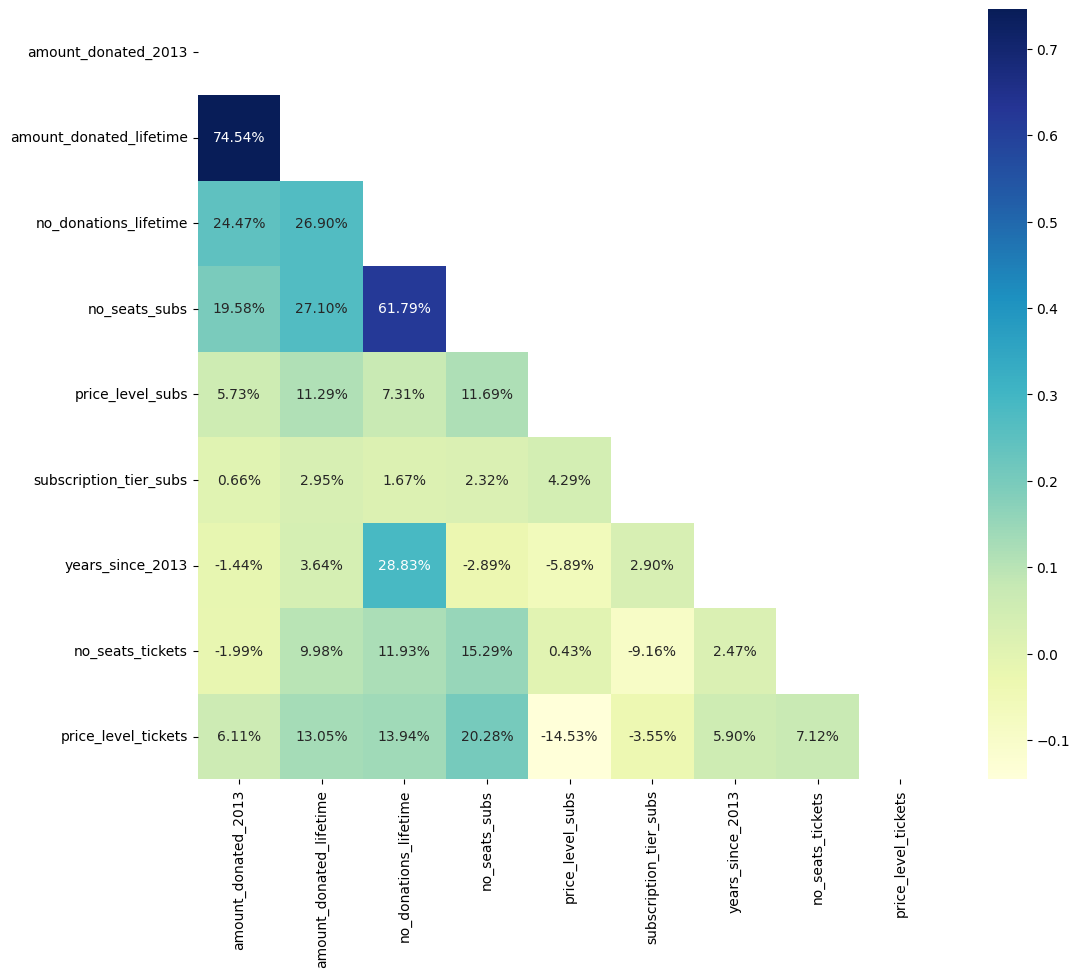

In [25]:
fig = plt.figure(figsize=(12, 10))

corr = df_train[correlation_cols].corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    fmt=".2%",
    cmap="YlGnBu",
    mask=np.triu(corr),
)


In [26]:
df_train.columns

Index(['account_id', 'amount_donated_2013', 'amount_donated_lifetime',
       'no_donations_lifetime', 'label', 'no_seats_tickets',
       'price_level_tickets', 'no_seats_subs', 'price_level_subs',
       'subscription_tier_subs', 'years_since_2013', 'zip_reduced',
       'zip_matched'],
      dtype='object')

In [27]:
df_train.isnull().sum()

account_id                    0
amount_donated_2013           0
amount_donated_lifetime       0
no_donations_lifetime         0
label                         0
no_seats_tickets           6214
price_level_tickets        6214
no_seats_subs              4736
price_level_subs           4736
subscription_tier_subs     4736
years_since_2013           5007
zip_reduced                 980
zip_matched                   0
dtype: int64

In [28]:
df_test.isnull().sum()

account_id                    0
amount_donated_2013           0
amount_donated_lifetime       0
no_donations_lifetime         0
no_seats_tickets           2683
price_level_tickets        2683
no_seats_subs              2032
price_level_subs           2032
subscription_tier_subs     2032
years_since_2013           2118
zip_reduced                 472
zip_matched                   0
dtype: int64

### Missing Values

In [29]:
df_train['no_seats_tickets'] = df_train['no_seats_tickets'].fillna(df_train['no_seats_tickets'].mean())
df_train['price_level_tickets'] = df_train['price_level_tickets'].fillna(df_train['price_level_tickets'].mean())
df_train['no_seats_subs'] = df_train['no_seats_subs'].fillna(df_train['no_seats_subs'].mean())
df_train['price_level_subs'] = df_train['price_level_subs'].fillna(df_train['price_level_subs'].mean())
df_train['subscription_tier_subs'] = df_train['subscription_tier_subs'].fillna(df_train['subscription_tier_subs'].mean())
df_train['years_since_2013'] = df_train['years_since_2013'].fillna(df_train['years_since_2013'].mean())
df_train['zip_reduced'] = df_train['zip_reduced'].fillna('nan')

df_test['no_seats_tickets'] = df_test['no_seats_tickets'].fillna(df_test['no_seats_tickets'].mean())
df_test['price_level_tickets'] = df_test['price_level_tickets'].fillna(df_test['price_level_tickets'].mean())
df_train['no_seats_subs'] = df_train['no_seats_subs'].fillna(df_test['no_seats_subs'].mean())
df_train['price_level_subs'] = df_train['price_level_subs'].fillna(df_test['price_level_subs'].mean())
df_test['subscription_tier_subs'] = df_test['subscription_tier_subs'].fillna(df_test['subscription_tier_subs'].mean())
df_test['years_since_2013'] = df_test['years_since_2013'].fillna(df_test['years_since_2013'].mean())
df_test['zip_reduced'] = df_test['zip_reduced'].fillna('nan')



In [30]:
num_cols = ['amount_donated_2013', 'amount_donated_lifetime', 'no_seats_tickets', 'price_level_tickets',
            'no_donations_lifetime', 'no_seats_subs', 'price_level_subs', 'subscription_tier_subs', 'years_since_2013']
cat_cols = ['zip_reduced', 'zip_matched']

num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols),
                                               ('cat', cat_transformer, cat_cols)])

# preprocessor = StandardScaler()
# Fit and transform the training data
X_train = df_train.drop(['account_id', 'label'], axis=1)
y_train = df_train['label']
X_train = preprocessor.fit_transform(X_train)

# Transform the test data
X_test = df_test.drop(['account_id'], axis=1)
X_test = preprocessor.transform(X_test)

X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [31]:
print(X_train_val.shape, X_val.shape, y_train_val.shape, y_val.shape)

(4858, 95) (2083, 95) (4858,) (2083,)


### handle imbalanced set

In [32]:
sm = SMOTE(random_state=0)
X_sm,y_sm = sm.fit_resample(X_train_val, y_train_val)
print(f'''Shape of X before SMOTE: {X_train_val.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (4858, 95)
Shape of X after SMOTE: (9256, 95)

Balance of positive and negative classes (%):


0    50.0
1    50.0
Name: label, dtype: float64

In [33]:
verbose=False
n_jobs = 4

# Define our models to try
clf_lr = LogisticRegression(n_jobs=n_jobs, verbose=verbose, random_state=0)
clf_knn = KNeighborsClassifier(n_jobs=n_jobs,n_neighbors=5)
clf_rf = RandomForestClassifier(n_jobs=n_jobs, verbose=verbose, random_state=0)
clf_gbt = XGBClassifier(random_state=0)

names = ['LR','KNN','RF','GBT']
clfs = [clf_lr,clf_knn,clf_rf,clf_gbt]

fpr, tpr, precision, recall, auc_roc, ap = dict(),dict(),dict(),dict(),dict(),dict()
time_train, time_predict = dict(), dict() 

# Define the cross-validation parameters
cv = 5
scoring = 'roc_auc'

for i, clf in enumerate(clfs):
    print(f'Training {names[i]}')
    t0 = time.time()
    
    # Use grid search with cross-validation to train the model and optimize hyperparameters
    if names[i] == 'LR':
        param_grid = {'C': [0.1, 1, 10, 100], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    elif names[i] == 'KNN':
        param_grid = {'n_neighbors': [3, 5, 7]}
    elif names[i] == 'RF':
        param_grid = {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    elif names[i] == 'GBT':
        param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 6, 9]}
        
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=verbose)
    grid_search.fit(X_sm, y_sm)
    time_train[i] = (time.time() - t0) / 60
    print(f'Trained {names[i]} in {time_train[i]} min')
    print(f'{cv}-fold cross-validation {scoring}: {grid_search.best_score_:.4f}')
    print(f'Best hyperparameters: {grid_search.best_params_}')
    
    # Fit the best model on the full training set and predict on the validation set
    t0 = time.time()
    clf_best = grid_search.best_estimator_
    print(f'Best estimator: {clf_best}')
    clf_best.fit(X_train, y_train)
    scores = clf_best.predict_proba(X_val)
    time_predict[i] = (time.time() - t0) / 60
    print(f'Predicted {names[i]} in {time_predict[i]} min')
    
    # Evaluate performance metrics for each model
    fpr[i], tpr[i], _ = roc_curve(y_val, scores[:,1], pos_label=1)
    precision[i], recall[i], _ = precision_recall_curve(y_val, scores[:,1], pos_label=1)
    auc_roc[i] = auc(fpr[i], tpr[i]) 
    ap[i] = average_precision_score(y_val, scores[:,1])
    
    print("\n")

Training LR


/Users/vickinomwesigwa/Documents/Duke/AIPI520/Kaggle Competition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/Users/vickinomwesigwa/Documents/Duke/AIPI520/Kaggle Competition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/Users/vickinomwesigwa/Documents/Duke/AIPI520/Kaggle Competition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/Users/vickinomwesigwa/Documents/Duke/AIPI520/Kaggle Competition/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set

Trained LR in 0.020126354694366456 min
5-fold cross-validation roc_auc: 0.9785
Best hyperparameters: {'C': 10, 'solver': 'lbfgs'}
Best estimator: LogisticRegression(C=10, n_jobs=4, random_state=0, verbose=False)
Predicted LR in 0.00039930343627929686 min


Training KNN
Trained KNN in 0.051494061946868896 min
5-fold cross-validation roc_auc: 0.9677
Best hyperparameters: {'n_neighbors': 3}
Best estimator: KNeighborsClassifier(n_jobs=4, n_neighbors=3)
Predicted KNN in 0.003374115626017253 min


Training RF
Trained RF in 3.1394829511642457 min
5-fold cross-validation roc_auc: 0.9904
Best hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best estimator: RandomForestClassifier(max_depth=20, min_samples_split=5, n_jobs=4,
                       random_state=0, verbose=False)
Predicted RF in 0.002295851707458496 min


Training GBT
Trained GBT in 0.3467248320579529 min
5-fold cross-validation roc_auc: 0.9904
Best hyperparameters: {'learning_

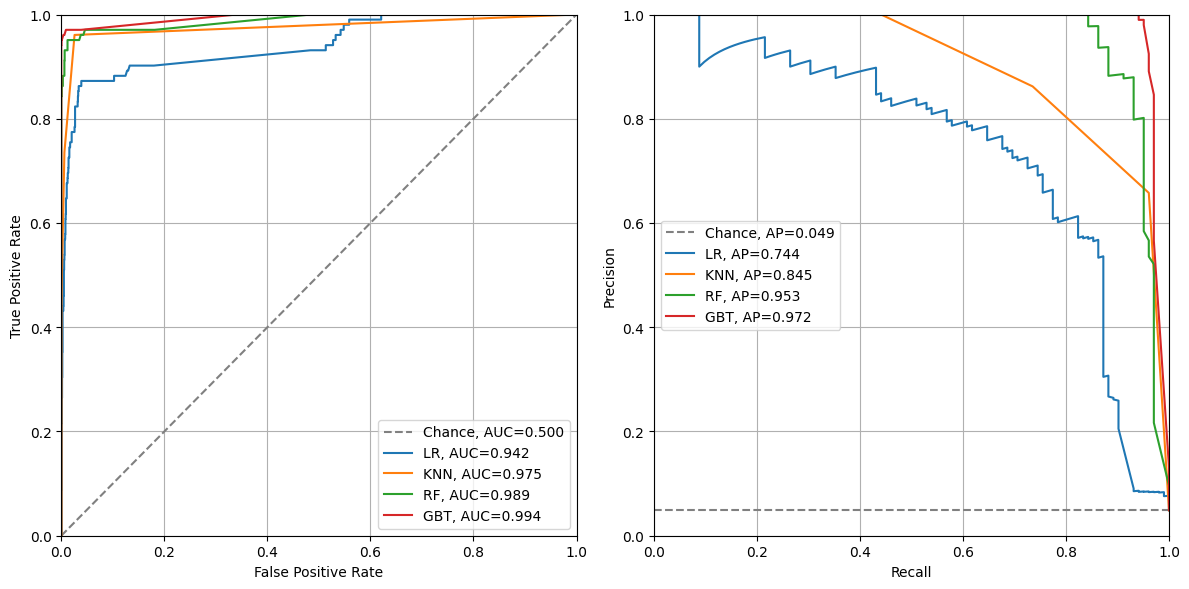

In [34]:
################################
# Plot performance
################################
import matplotlib.pyplot as plt

def add_roc(ax, fpr, tpr, auc, name, **kwargs):
    ax.plot(fpr, tpr, label='{}, AUC={:0.3f}'.format(name,auc), **kwargs)

def add_pr(ax, recall, precision, ap, name, **kwargs):
    ax.plot(recall, precision, label='{}, AP={:0.3f}'.format(name,ap), **kwargs)


# Plot the ROC curves
fig, (ax_roc, ax_pr) = plt.subplots(1,2,figsize=(12,6))

# Plot chance
pos_ratio = sum(y_val) / len(y_val)
add_roc(ax_roc, [0,1], [0,1], 0.5, 'Chance', color='grey', linestyle='--')
add_pr(ax_pr, [0,1], [pos_ratio, pos_ratio], pos_ratio, 'Chance', color='grey', linestyle='--')

# Plot each curve
for i, name in enumerate(names):
    add_roc(ax_roc, fpr[i], tpr[i], auc_roc[i], name)
    add_pr(ax_pr, recall[i], precision[i], ap[i], name)

# ROC Curve Formatting
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_xlim([0,1])
ax_roc.set_ylim([0,1])
ax_roc.grid(True)
ax_roc.legend()

# PR Curve Formatting
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')
ax_pr.set_xlim([0,1])
ax_pr.set_ylim([0,1])
ax_pr.grid(True)
ax_pr.legend()

plt.tight_layout()

In [35]:
################################
# Produce submission
################################

# Retrain the best classifier on all of the training data
conf_scores = clf_best.predict_proba(X_test)
df_test['Predicted'] =conf_scores[:,1]
df_test.head()


,account_id,amount_donated_2013,amount_donated_lifetime,no_donations_lifetime,no_seats_tickets,price_level_tickets,no_seats_subs,price_level_subs,subscription_tier_subs,years_since_2013,zip_reduced,zip_matched,Predicted
0,001i000000LhyPF,1500.0,28435.00,28,64.020548,1.465753,233.0,5.0,1.0,27.0,94,2,0.744737
1,001i000000LhyPG,300.0,4969.00,16,64.020548,1.465753,228.0,5.0,1.0,16.0,94,2,0.999917
2,001i000000LhyPP,0.0,4047.96,21,64.020548,1.465753,227.0,0.0,1.0,15.0,94,2,0.998697
3,001i000000LhyPb,0.0,5600.00,8,64.020548,1.465753,212.0,5.0,0.0,6.0,94,2,0.997053
4,001i000000LhyPg,150.0,3678.00,35,64.020548,1.465753,237.0,0.0,1.0,25.0,94,2,0.999813


In [36]:
submission_df = df_test[['account_id','Predicted']]
submission_df.rename(columns={'account_id':'ID'}, inplace=True)
submission_df.to_csv('submission_6.csv', index=False)

/var/folders/tw/zk7ymqls43g56yxwgmpk9p3r0000gn/T/ipykernel_38145/3144437690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df.rename(columns={'account_id':'ID'}, inplace=True)
